In [1]:
import numpy as np
import pandas as pd
import altair as alt
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from collections import Counter
from imblearn.over_sampling import SMOTE
import keras_tuner as kt

2.7.0


In [2]:
# import dataset into colab
%store -r IMBALANCED_TRAIN_VAL 
%store -r RESAMPLED_TRAIN_VAL 
%store -r TEST 
imbalanced_train_val=IMBALANCED_TRAIN_VAL.copy()
resampled_train_val= RESAMPLED_TRAIN_VAL.copy()
test= TEST.copy()

In [3]:
# Drop unwanted  columns
print(imbalanced_train_val.shape, 'imbalanced_train_val examples')
print(resampled_train_val.shape, 'resampled_train_val examples')
print(test.shape, 'test examples')

(82332, 43) imbalanced_train_val examples
(370000, 43) resampled_train_val examples
(175341, 43) test examples


In [4]:
imbalanced_train,imbalanced_val = train_test_split(imbalanced_train_val, test_size=0.2, random_state = 1)
resampled_train,resampled_val = train_test_split(resampled_train_val, test_size=0.2, random_state = 1)
CLASSES=['Normal','Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']
BATCH_SIZE = 32
EPOCHS = 100
MODELS_RESULTS={}
N_TRAIN=len(imbalanced_train)
N_RES_TRAIN=len(resampled_train)
N_VAL=len(imbalanced_val)
N_RES_VAL=len(resampled_val)
N_TEST=len(test)
print('___TEST________________________________________________')
print(test.shape, 'test shape')
print(N_TEST, 'test count')
print('________________________________________________________')
print('___IMBALANCED___________________________________________')
print(imbalanced_train_val.shape, 'training shape')
print(N_TRAIN, 'training examples')
print(N_VAL, 'validation examples')
print('_________________________________________________________')
print('___BALANCED______________________________________________')
print(resampled_train_val.shape, 'training shape')
print(N_RES_TRAIN, 'training examples')
print(N_RES_VAL, 'validation examples')
print('_________________________________________________________')
print(CLASSES)

___TEST________________________________________________
(175341, 43) test shape
175341 test count
________________________________________________________
___IMBALANCED___________________________________________
(82332, 43) training shape
65865 training examples
16467 validation examples
_________________________________________________________
___BALANCED______________________________________________
(370000, 43) training shape
296000 training examples
74000 validation examples
_________________________________________________________
['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']


In [5]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2021-12-20 15:45:05.932077: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
regularizers=tf.keras.regularizers.l2(0.001)
def group_dtype(data):
    # data=data.drop(columns=DROP_COL)
    columns=data.columns # get list of columns
    unique=data.dtypes.unique() # select one of each dtype
    result={'number_col':[],'string_category_col':[],'int_category_col':[],'labels':[]}
    for col in columns:
        if col=='attack_cat': 
            temp= result['labels'] # init array
        elif data[col].dtypes=='float64': 
            temp= result['number_col'] # init array
        elif data[col].dtypes=='int64':
             temp= result['int_category_col'] # init array
        else:
            temp= result['string_category_col'] # init array
        temp.append(col) # append the array
    return result
    
def plot_model_graph(history,name):
    plt.figure(figsize=(8, 30))
    names =['loss','accuracy','precision','recall','prc','auc']
    c=0
    for n in names:
        c=c+1
        n_val = 'val_'+n
        hist = history.history[n]
        hist_val = history.history[n_val]
        plt.subplot(len(names),1,c)
        plt.plot(hist, label='Training {}'.format(n))
        plt.plot(hist_val, label='Validation {}'.format(n))
        plt.legend(loc='lower right')
        plt.ylabel(n)
        plt.ylim(0.4,1)
        plt.title('{} Training and Validation {}'.format(name,n))
    plt.xlabel('epoch')
    return plt

def dataframe_to_dataset(dataframe):
    attack_cat=dataframe.pop('attack_cat')
    x_num=tf.convert_to_tensor(dataframe[number_col])
    x_string=tf.convert_to_tensor(dataframe[string_category_col])
    x_int=tf.convert_to_tensor(dataframe[int_category_col])
    attack_cat = attack_cat.map(CLASSES.index)
    y=tf.keras.utils.to_categorical(attack_cat, num_classes=10)
    return [x_num,x_string,x_int],y

In [7]:
_col = group_dtype(imbalanced_train) # return result from
number_col=_col['number_col']
string_category_col=_col['string_category_col']
int_category_col=_col['int_category_col']

In [8]:
dataframe = imbalanced_train.copy()
_ds= dataframe_to_dataset(dataframe)
X,y=_ds
input_num_shape = X[0].shape[1:]
input_string_shape = X[1].shape[1:]
input_int_shape = X[2].shape[1:]
classes = 10
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(X[0])
# Create a Intlookup layer and set its internal state using the training data
string_lookup = layers.StringLookup(output_mode="multi_hot")
string_lookup.adapt(X[1])
string_vocabulary=string_lookup.get_vocabulary()
# Create a Intlookup layer and set its internal state using the training data
int_lookup = layers.IntegerLookup( output_mode="multi_hot")
int_lookup.adapt(X[2])
int_vocabulary=int_lookup.get_vocabulary()

In [9]:
def evaluation(model,train_ds,val_ds,test_ds,name):
    X_train,y_train=train_ds
    X_val,y_val=val_ds
    X_test,y_test=test_ds
    project_name='HYPERPARAM_'+name
    tuner = kt.Hyperband(model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
    
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
    tuner.search(X_train, y_train, epochs=50, validation_data=[X_val,y_val], callbacks=[stop_early])
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete for {name}. The optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.
    """)
    summary=tuner.results_summary(num_trials=1)
    print("summary")
    print(summary)
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    model = tuner.hypermodel.build(best_hps)
    print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
    history = model.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val,y_val])
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))
#   Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
    hypermodel = tuner.hypermodel.build(best_hps)
    # Retrain the model
    print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
    history = hypermodel.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=best_epoch, validation_data=[X_val,y_val])
    MODELS_RESULTS[name]={}
    print('----')
    print('----')
    print('evaluation result model for:{} on TRAIN_________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_train,y_train)
    MODELS_RESULTS[name]['train']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('evaluation result model for:{} on VALIDATION________________________________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_val,y_val)
    MODELS_RESULTS[name]['validation']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('evaluation result model for:{} on TEST________________________________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_test,y_test)
    MODELS_RESULTS[name]['test']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('plot:{}_________________________________________________________'.format(name))
    plot_model_graph(history,name)
    return hypermodel

In [10]:
# # Load some data
def build_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
   # include the normalization layer
    x1 = normalizer(input_num)
   # Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
   # include the int_lookup layer
    x2 = int_lookup(input_int)
   # Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
   # include the int_lookup layer
    x3 = string_lookup(input_string)
    concat = tf.keras.layers.Concatenate(axis=1)([x1,x2,x3])
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    x = layers.Dense(hp_units_1,activation='relu',kernel_regularizer=regularizers)(concat)
    x = layers.Dropout(0.5)(x)
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_2,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_3,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    output = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    print('MODAL-SUMMARY')
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

Trial 30 Complete [01h 10m 20s]
val_accuracy: 0.8320276737213135

Best val_accuracy So Far: 0.8383433818817139
Total elapsed time: 16h 11m 06s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete for EAIRLY-FUSION-IMBALANCED. The optimal number of units in the first densely-connected
    layer is 128 and the optimal learning rate for the optimizer
    is 0.0001.
    
MODAL-SUMMARY
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                    

2059/2059 [==============================] - 244s 118ms/step - loss: 0.4507 - accuracy: 0.8481 - precision: 0.9207 - recall: 0.7983 - auc: 0.9916 - prc: 0.9458 - val_loss: 0.4758 - val_accuracy: 0.8413 - val_precision: 0.9180 - val_recall: 0.7868 - val_auc: 0.9904 - val_prc: 0.9401
Epoch 15/100
2059/2059 [==============================] - 251s 122ms/step - loss: 0.4467 - accuracy: 0.8505 - precision: 0.9237 - recall: 0.7998 - auc: 0.9918 - prc: 0.9468 - val_loss: 0.4746 - val_accuracy: 0.8405 - val_precision: 0.9148 - val_recall: 0.7910 - val_auc: 0.9903 - val_prc: 0.9399
Epoch 16/100
2059/2059 [==============================] - 259s 126ms/step - loss: 0.4424 - accuracy: 0.8509 - precision: 0.9245 - recall: 0.8006 - auc: 0.9920 - prc: 0.9478 - val_loss: 0.4716 - val_accuracy: 0.8420 - val_precision: 0.9173 - val_recall: 0.7896 - val_auc: 0.9906 - val_prc: 0.9412
Epoch 17/100
2059/2059 [==============================] - 256s 125ms/step - loss: 0.4393 - accuracy: 0.8521 - precision: 0.92

2059/2059 [==============================] - 169s 82ms/step - loss: 0.3729 - accuracy: 0.8832 - precision: 0.9459 - recall: 0.8390 - auc: 0.9951 - prc: 0.9665 - val_loss: 0.4791 - val_accuracy: 0.8453 - val_precision: 0.9100 - val_recall: 0.8042 - val_auc: 0.9900 - val_prc: 0.9423
Epoch 42/100
2059/2059 [==============================] - 171s 83ms/step - loss: 0.3712 - accuracy: 0.8833 - precision: 0.9448 - recall: 0.8406 - auc: 0.9951 - prc: 0.9669 - val_loss: 0.4806 - val_accuracy: 0.8425 - val_precision: 0.9159 - val_recall: 0.8012 - val_auc: 0.9899 - val_prc: 0.9425
Epoch 43/100
2059/2059 [==============================] - 171s 83ms/step - loss: 0.3702 - accuracy: 0.8830 - precision: 0.9460 - recall: 0.8400 - auc: 0.9952 - prc: 0.9669 - val_loss: 0.4778 - val_accuracy: 0.8437 - val_precision: 0.9149 - val_recall: 0.8022 - val_auc: 0.9900 - val_prc: 0.9429
Epoch 44/100
2059/2059 [==============================] - 178s 86ms/step - loss: 0.3657 - accuracy: 0.8857 - precision: 0.9477 -

Epoch 69/100
2059/2059 [==============================] - 254s 123ms/step - loss: 0.3348 - accuracy: 0.8952 - precision: 0.9556 - recall: 0.8578 - auc: 0.9962 - prc: 0.9736 - val_loss: 0.4990 - val_accuracy: 0.8425 - val_precision: 0.9072 - val_recall: 0.8034 - val_auc: 0.9882 - val_prc: 0.9391
Epoch 70/100
2059/2059 [==============================] - 227s 110ms/step - loss: 0.3349 - accuracy: 0.8958 - precision: 0.9543 - recall: 0.8568 - auc: 0.9961 - prc: 0.9735 - val_loss: 0.4999 - val_accuracy: 0.8447 - val_precision: 0.9065 - val_recall: 0.8038 - val_auc: 0.9882 - val_prc: 0.9390
Epoch 71/100
2059/2059 [==============================] - 254s 123ms/step - loss: 0.3337 - accuracy: 0.8956 - precision: 0.9559 - recall: 0.8569 - auc: 0.9962 - prc: 0.9737 - val_loss: 0.5024 - val_accuracy: 0.8368 - val_precision: 0.9025 - val_recall: 0.8000 - val_auc: 0.9883 - val_prc: 0.9376
Epoch 72/100
2059/2059 [==============================] - 242s 118ms/step - loss: 0.3318 - accuracy: 0.8980 - pr

2059/2059 [==============================] - 252s 123ms/step - loss: 0.3170 - accuracy: 0.9006 - precision: 0.9590 - recall: 0.8629 - auc: 0.9965 - prc: 0.9761 - val_loss: 0.5151 - val_accuracy: 0.8429 - val_precision: 0.9047 - val_recall: 0.8040 - val_auc: 0.9868 - val_prc: 0.9368
Epoch 97/100
2059/2059 [==============================] - 246s 120ms/step - loss: 0.3178 - accuracy: 0.9005 - precision: 0.9582 - recall: 0.8629 - auc: 0.9965 - prc: 0.9759 - val_loss: 0.5203 - val_accuracy: 0.8443 - val_precision: 0.8976 - val_recall: 0.8125 - val_auc: 0.9862 - val_prc: 0.9359
Epoch 98/100
2059/2059 [==============================] - 257s 125ms/step - loss: 0.3172 - accuracy: 0.9005 - precision: 0.9577 - recall: 0.8626 - auc: 0.9966 - prc: 0.9759 - val_loss: 0.5236 - val_accuracy: 0.8429 - val_precision: 0.9052 - val_recall: 0.8040 - val_auc: 0.9862 - val_prc: 0.9350
Epoch 99/100
2059/2059 [==============================] - 256s 124ms/step - loss: 0.3170 - accuracy: 0.9003 - precision: 0.95

2059/2059 [==============================] - 238s 116ms/step - loss: 0.4678 - accuracy: 0.8427 - precision: 0.9181 - recall: 0.7914 - auc: 0.9909 - prc: 0.9420 - val_loss: 0.4854 - val_accuracy: 0.8359 - val_precision: 0.9132 - val_recall: 0.7825 - val_auc: 0.9898 - val_prc: 0.9375
Epoch 11/90
2059/2059 [==============================] - 238s 116ms/step - loss: 0.4633 - accuracy: 0.8441 - precision: 0.9192 - recall: 0.7919 - auc: 0.9911 - prc: 0.9428 - val_loss: 0.4859 - val_accuracy: 0.8348 - val_precision: 0.9115 - val_recall: 0.7842 - val_auc: 0.9897 - val_prc: 0.9373
Epoch 12/90
2059/2059 [==============================] - 240s 116ms/step - loss: 0.4579 - accuracy: 0.8446 - precision: 0.9196 - recall: 0.7937 - auc: 0.9913 - prc: 0.9440 - val_loss: 0.4773 - val_accuracy: 0.8391 - val_precision: 0.9171 - val_recall: 0.7851 - val_auc: 0.9903 - val_prc: 0.9393
Epoch 13/90
2059/2059 [==============================] - 240s 117ms/step - loss: 0.4534 - accuracy: 0.8477 - precision: 0.9217 

Epoch 38/90
2059/2059 [==============================] - 262s 127ms/step - loss: 0.3798 - accuracy: 0.8793 - precision: 0.9429 - recall: 0.8355 - auc: 0.9948 - prc: 0.9647 - val_loss: 0.4773 - val_accuracy: 0.8451 - val_precision: 0.9129 - val_recall: 0.8040 - val_auc: 0.9902 - val_prc: 0.9431
Epoch 39/90
2059/2059 [==============================] - 259s 126ms/step - loss: 0.3768 - accuracy: 0.8807 - precision: 0.9436 - recall: 0.8368 - auc: 0.9949 - prc: 0.9653 - val_loss: 0.4803 - val_accuracy: 0.8451 - val_precision: 0.9098 - val_recall: 0.8016 - val_auc: 0.9899 - val_prc: 0.9421
Epoch 40/90
2059/2059 [==============================] - 261s 127ms/step - loss: 0.3746 - accuracy: 0.8820 - precision: 0.9454 - recall: 0.8387 - auc: 0.9950 - prc: 0.9660 - val_loss: 0.4812 - val_accuracy: 0.8452 - val_precision: 0.9080 - val_recall: 0.8026 - val_auc: 0.9901 - val_prc: 0.9417
Epoch 41/90
2059/2059 [==============================] - 268s 130ms/step - loss: 0.3726 - accuracy: 0.8835 - precis

2059/2059 [==============================] - 233s 113ms/step - loss: 0.3378 - accuracy: 0.8955 - precision: 0.9551 - recall: 0.8578 - auc: 0.9961 - prc: 0.9733 - val_loss: 0.5060 - val_accuracy: 0.8441 - val_precision: 0.9057 - val_recall: 0.8056 - val_auc: 0.9878 - val_prc: 0.9382
Epoch 66/90
2059/2059 [==============================] - 238s 116ms/step - loss: 0.3380 - accuracy: 0.8962 - precision: 0.9541 - recall: 0.8562 - auc: 0.9961 - prc: 0.9733 - val_loss: 0.5023 - val_accuracy: 0.8370 - val_precision: 0.9066 - val_recall: 0.7983 - val_auc: 0.9881 - val_prc: 0.9374
Epoch 67/90
2059/2059 [==============================] - 235s 114ms/step - loss: 0.3362 - accuracy: 0.8957 - precision: 0.9556 - recall: 0.8568 - auc: 0.9962 - prc: 0.9735 - val_loss: 0.4983 - val_accuracy: 0.8408 - val_precision: 0.9050 - val_recall: 0.8019 - val_auc: 0.9886 - val_prc: 0.9387
Epoch 68/90
2059/2059 [==============================] - 245s 119ms/step - loss: 0.3355 - accuracy: 0.8969 - precision: 0.9556 

515/515 [==============================] - 13s 26ms/step - loss: 0.5175 - accuracy: 0.8444 - precision: 0.9001 - recall: 0.8088 - auc: 0.9869 - prc: 0.9371
loss:0.517469048500061 -accuracy:0.844416081905365 - precision:0.9001081585884094 - recall:0.8087690472602844 - auc:0.986932635307312 - prc:0.9370540380477905
----
----
evaluation result model for:EAIRLY-FUSION-IMBALANCED on TEST________________________________________________________________________________
5480/5480 [==============================] - 143s 26ms/step - loss: 0.8111 - accuracy: 0.7648 - precision: 0.8353 - recall: 0.7159 - auc: 0.9691 - prc: 0.8696
loss:0.8111092448234558 -accuracy:0.764784038066864 - precision:0.8353486061096191 - recall:0.7159021496772766 - auc:0.9691238403320312 - prc:0.8695628643035889
----
----
plot:EAIRLY-FUSION-IMBALANCED_________________________________________________________


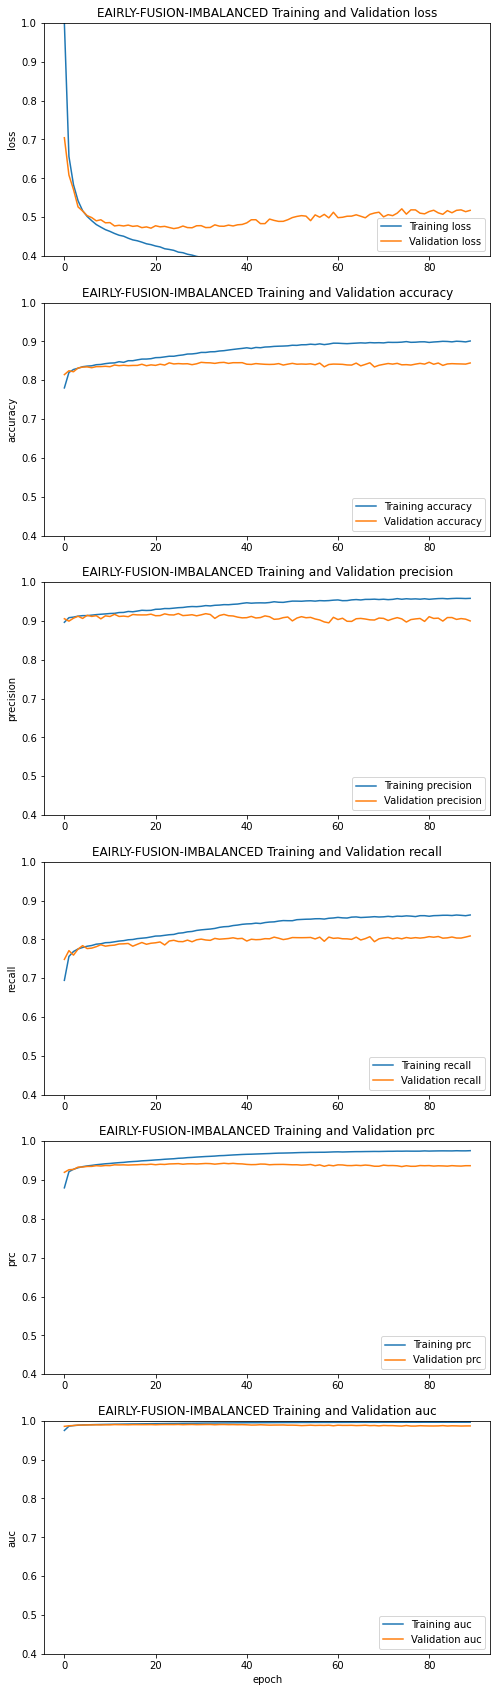

In [11]:
# EAIRLY-FUSION-IMBALANCED
dataframe = imbalanced_train.copy()
train_ds= dataframe_to_dataset(dataframe)
dataframe = imbalanced_val.copy()
val_ds= dataframe_to_dataset(dataframe)
dataframe = test.copy()
test_ds= dataframe_to_dataset(dataframe)

print('EAIRLY-FUSION-IMBALANCED')
model= evaluation(build_model,train_ds,val_ds,test_ds,'EAIRLY-FUSION-IMBALANCED')


In [ ]:
# EAIRLY-FUSION-BALANCED
dataframe = resampled_train.copy()
train_ds= dataframe_to_dataset(dataframe)
dataframe = resampled_val.copy()
val_ds= dataframe_to_dataset(dataframe)
dataframe = test.copy()
test_ds= dataframe_to_dataset(dataframe)
print('EAIRLY-FUSION-BALANCED')
model= evaluation(build_model,train_ds,val_ds,test_ds,'EAIRLY-FUSION-BALANCED')

Trial 31 Complete [08h 12m 05s]
val_accuracy: 0.7514054179191589

Best val_accuracy So Far: 0.7514054179191589
Total elapsed time: 05h 24m 20s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete for EAIRLY-FUSION-BALANCED. The optimal number of units in the first densely-connected
    layer is 384 and the optimal learning rate for the optimizer
    is 0.0001.
    
MODAL-SUMMARY
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                      

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
EAIRLY_FUSION_RESULTS=MODELS_RESULTS
%store EAIRLY_FUSION_RESULTS